
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./diffusion.ipynb" download="diffusion.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=diffusion.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/TH2M/H/diffusion/diffusion.py"><img src="https://img.shields.io/static/v1?label=Source:&message=diffusion.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/TH2M/H/diffusion/diffusion.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

|<div style="width:300px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:300px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="300"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

# 1D Linear Diffusion

## Analytical Solution

The solution of the diffusion equation for a point x in time t reads:

$ c(x,t) = \left(c_0-c_i\right)\operatorname{erfc}\left(\frac{x}{\sqrt{4Dt}}\right)+c_i$

where $c$ is the concentration of a solute in mol$\cdot$m$^{-3}$, $c_i$ and $c_b$ are initial and boundary concentrations; $D$ is the diffusion coefficient of the solute in water, x and t are location and time of solution.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv
from scipy.special import erfc

In [2]:
def Diffusion(x, t):
    "Analytical solution of the diffusion equation"
    d = np.sqrt(4 * D * t)
    return (c_b - c_i) * erfc(
        np.divide(x, d, where=(d != 0), out=np.ones_like(x * d) * 1e6)
    ) + c_i


def concentration(xm_WL):
    "Utility-function transforming mass fraction into conctration"
    xm_CL = 1.0 - xm_WL
    return xm_CL / beta_c

### Material properties and problem specification

In [3]:
H = 7.65e-6  # Henry-coefficien
beta_c = 2.0e-6  # Compressibility of solution
D = 1.0e-9  # Diffusion coefficient
pGR_b = 9e5  # Boundary gas pressure
pGR_i = 1e5  # Initial gas pressure
c_b = concentration(1.0 - (beta_c * H * pGR_b))  # Boundary concentration
c_i = concentration(1.0 - (beta_c * H * pGR_i))  # Initial concentration

## Numerical Solution

In [4]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [5]:
model = ot.Project(input_file="diffusion.prj", output_file=f"{out_dir}/modified.prj")
timestepping = "./time_loop/processes/process/time_stepping"
model.replace_text(1e7, xpath=f"{timestepping}/t_end")
model.replace_text(5e4, xpath=f"{timestepping}/timesteps/pair/delta_t")
model.replace_text(1, xpath="./time_loop/output/timesteps/pair/each_steps")
model.replace_text("XDMF", xpath="./time_loop/output/type")
model.write_input()
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m .")

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/TH2M/H/diffusion/diffusion/modified.prj
Status: finished successfully.
Execution took 20.50320553779602 s


In [6]:
ms = ot.MeshSeries(f"{out_dir}/result_diffusion_domain.xdmf")

def plot_results_errors(x: np.ndarray, y: np.ndarray, y_ref: np.ndarray,
         labels: list, x_label: str, colors: list):  # fmt: skip
    "Plot numerical results against analytical solution"
    rel_errors = (np.asarray(y_ref) - np.asarray(y)) / np.asarray(y_ref)
    assert np.all(np.abs(rel_errors) <= 0.3)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.set_xlabel(x_label, fontsize=12)
    ax2.set_xlabel(x_label, fontsize=12)
    ax1.set_ylabel("$c$ / mol m$^{-3}$", fontsize=12)
    ax2.set_ylabel(r"$\epsilon_\mathrm{abs}$ / mol m$^{-3}$", fontsize=12)
    for i, rel_error in enumerate(rel_errors):
        ax1.plot(x, y[i], "--", lw=2, label=labels[i], c=colors[i])
        ax1.plot(x, y_ref[i], "-", lw=1, c=colors[i])
        ax2.plot(x, rel_error, "-", lw=2, label=labels[i], c=colors[i])
    ax1.plot([], [], "--k", label="OGS-TH2M")
    ax1.plot([], [], "-k", label="analytical")
    ax1.legend(loc="right")
    ax2.legend(loc="right")
    fig.tight_layout()

### Concentration vs. time at different locations

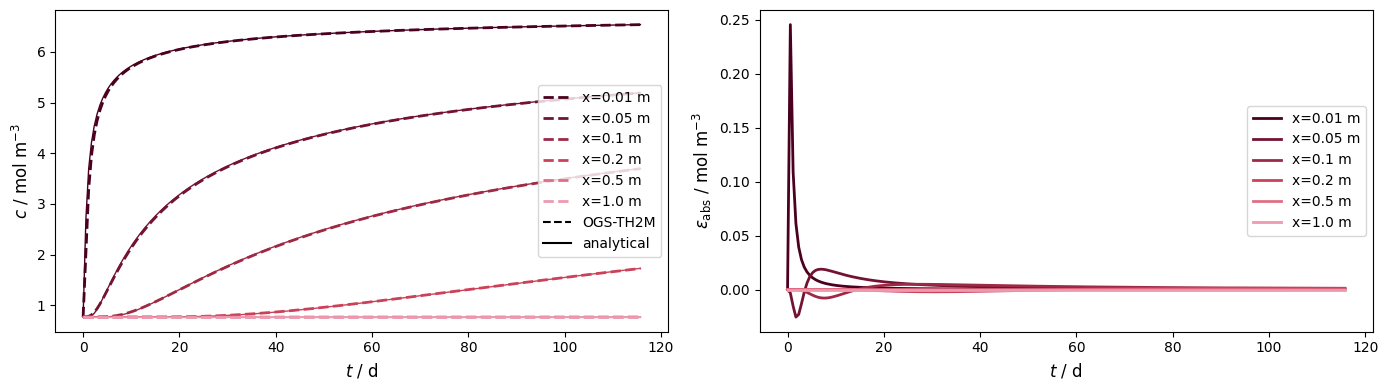

In [7]:
obs_pts = np.asarray([(x, 0, 0) for x in [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]])
num_values = concentration(ms.probe(obs_pts, "xmWL").T)
ref_values = [Diffusion(x, ms.timevalues) for x in obs_pts[:, 0]]
leg_labels = [f"x={pt[0]} m" for pt in obs_pts]
reds = ["#4a001e", "#731331", "#9f2945", "#cc415a", "#e06e85", "#ed9ab0"]
time = ms.timevalues / 3600 / 24
plot_results_errors(time, num_values, ref_values, leg_labels, "$t$ / d", reds)

### Concentration vs. location at different times

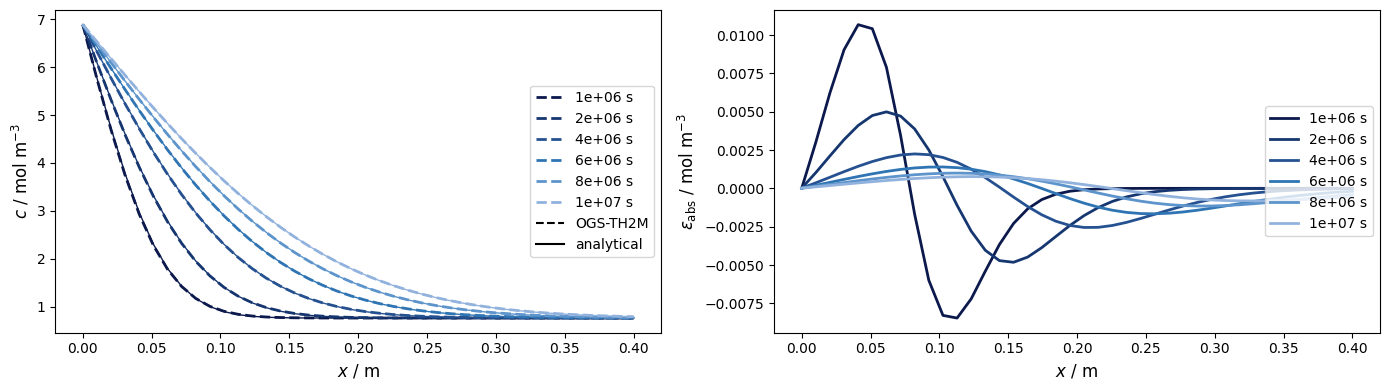

In [8]:
timevalues = np.asarray([1e6, 2e6, 4e6, 6e6, 8e6, 1e7])
timesteps = [ms.closest_timestep(tv) for tv in timevalues]
xs = np.linspace(0, 0.4, 40)
line = pv.PointSet([(x, 0, 0) for x in xs])
num_values = [concentration(line.sample(ms[ts])["xmWL"]) for ts in timesteps]
ref_values = [Diffusion(xs, tv) for tv in timevalues]
leg_labels = [f"{tv:.0e} s" for tv in timevalues]
blues = ["#0b194c", "#163670", "#265191", "#2f74b3", "#5d94cb", "#92b2de"]
plot_results_errors(xs, num_values, ref_values, leg_labels, "$x$ / m", blues)

The numerical approximation approaches the exact solution quite well.
Deviations can be reduced if the resolution of the temporal discretisation is
increased.

### Concentration over time and space

/var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/.venv/lib/python3.13/site-packages/ogstools/meshlib/mesh_series.py:910: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(x_vals, y_vals, values, cmap=cmap, norm=norm)


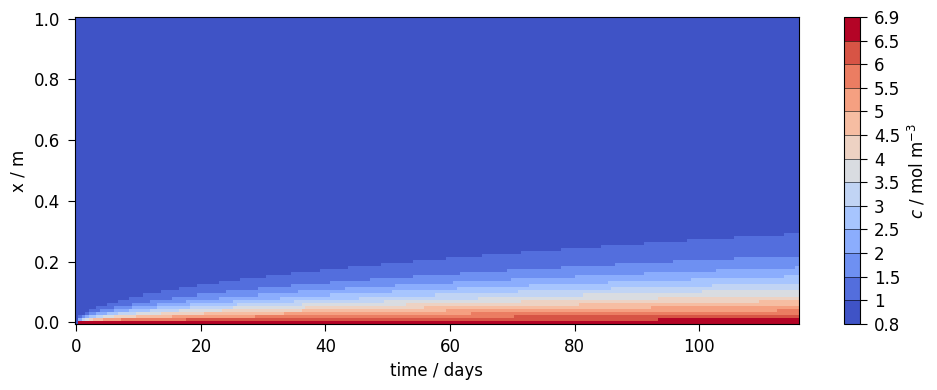

In [9]:
pts = np.linspace([0.0, 0.0, 0.0], [0.3, 0.0, 0.0], 500)
var = ot.variables.Scalar("xmWL", func=concentration)
ot.plot.setup.time_unit = "days"
fig = ms.scale(time=("s", "days")).plot_time_slice(
    "time", "x", var, figsize=[10, 4], fontsize=12
)
fig.axes[1].set_ylabel("$c$ / mol m$^{-3}$")
fig.tight_layout()